<a href="https://colab.research.google.com/github/FHU/FA24-CIS377-BT-n-JT-class-project/blob/main/AIGroupProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spiking Heidelberg Digits**

## Data Preprocessing

In [ ]:
!pip install -q tonic
!pip install -q norse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Tonic is our way to load in the data. The data's labels are 0-19, which represent spoken digits/numbers in English or German. The digits are 0 through 9.


For our SNN, the main hyperparameters for the setup of our data will be event_count, n_time_bins, n_event_bins, and overlap

In [ ]:
import tonic
from tonic import datasets, transforms
from torchvision.transforms import Compose
#from torchvision.transforms import ToTensor
# DON'T USE ToTensor, IT LITERALLY IS ONLY FOR IMAGES
# will have to use torch.from_numpy and iterate over all our lists.

shd = datasets.SHD(save_to="./data", train=False)
#two_transforms = Compose([ ToTensor(), transforms.ToFrame(time_window=10000, sensor_size=shd.sensor_size)])
transform_2frame_only = transforms.ToFrame(time_window=10000, sensor_size=shd.sensor_size)
# ToFrame info: https://tonic.readthedocs.io/en/latest/generated/tonic.transforms.ToFrame.html#tonic.transforms.ToFrame
trainset = datasets.SHD(save_to="./data", transform=transform_2frame_only, train=True)
testset = datasets.SHD(save_to="./data", transform=transform_2frame_only, train=False)

  0%|          | 0/38141465 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_test.h5.zip to ./data/SHD


  0%|          | 0/130863613 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_train.h5.zip to ./data/SHD


In [ ]:
de_max = 0
de_least = 9000000
for garf in range(8156):
  de_length = len(trainset[garf][0])
  #if 9 != garf % 10:
    #print(len(trainset[garf][0]), end='\t')
  #else:
    #print(len(trainset[garf][0]))
  if de_length > de_max:
    de_max = de_length
  if de_length < de_least:
    de_least = de_length

print("largest value for our time", de_max, "\n least value for our time", de_least)


largest value for our time 136 
 least value for our time 23


graph of item with label: 13 
of item: 900


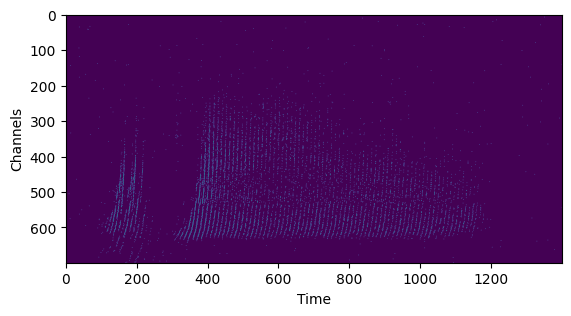

In [ ]:
an_item = 900
events, label = shd[an_item]
tonic.utils.plot_event_grid(events)
print("graph of item with label:",label,'\nof item:',an_item)

# animation doesn't work for sound

## Create Neural Network

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

#batch_size can be changed
batch_size = 256
trainloader = DataLoader(trainset, batch_size=batch_size,collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size,collate_fn=tonic.collation.PadTensors(batch_first=True))

In [ ]:
trainset.data

[]

In [ ]:
#original net that had to be rewritten
'''device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_layer = nn.Sequential(
            nn.Linear(700, 128),
            nn.Flatten(),
            nn.Linear(128*sample_size, 20)
        )

    def forward(self, x, sample_size):
      self.sample_size = sample_size
      x = self.model_layer(x, self.sample_size)
      return x
net = Net().to(device)
'''

'device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")\n\nclass Net(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.model_layer = nn.Sequential(\n            nn.Linear(700, 128),\n            nn.Flatten(),\n            nn.Linear(128*sample_size, 20)\n        )\n\n    def forward(self, x, sample_size):\n      self.sample_size = sample_size\n      x = self.model_layer(x, self.sample_size)\n      return x\nnet = Net().to(device)\n'

In [ ]:
#correct neural net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(700, 128)
        self.flatten = nn.Flatten()
        self.linear2 = None  # Placeholder for dynamically defined Linear layer

    def forward(self, x, sample_size):
        # Define the second linear layer dynamically based on sample_size
        self.sample_size = sample_size
        self.linear2 = nn.Linear(128 * self.sample_size, 20)

        # Perform forward pass
        x = self.linear1(x)
        x = self.flatten(x)
        x = self.linear2(x)
        return x

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net = Net().to(device)

## Train Neural Network

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from tqdm.notebook import tqdm
epochs = 10
for epoch in tqdm(range(epochs), desc="Epoch Progress", position=0):
    running_loss = 0.0
    with tqdm(total=len(trainloader), desc="Batch Progress", position=1, leave=False) as batch_bar:
        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            sample_size = inputs.shape[1]
            pred = net(inputs, sample_size)
            loss = criterion(pred, labels.to(torch.long))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_bar.update(1)

print('Finished Training')

PATH = './cifar_net.pt'
torch.save(net, PATH)

Epoch Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/32 [00:00<?, ?it/s]

Finished Training


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Evaluate Neural Network

In [ ]:
size_of_dataset = len(testloader.dataset)
num_batches = len(testloader)
#modifiyed from the code used in assignment 4 ImageClassification
# range is 20 because we have 20 classes.
correct_pred = {classname: 0 for classname in range(20)}
total_pred = {classname: 0 for classname in range(20)}

# for overall accuracy
total_correct = 0
total = 0

with tqdm(total=len(testloader), desc="Test Batch Progress", position=0) as batch_bar:
    for data in testloader:
        net.eval()
        # No optimizing because we are now testing the NN.
        # Mainly appropriated from assignment 4 PytorchBasics
        test_loss, correct = 0, 0
        with torch.no_grad():
          for X, y in testloader:
            # this gets our prediction and real stuff
            X, y = X.to(device), y.to(device)
            sample_size = X.shape[1]
            pred = net(X, sample_size)
            test_loss += criterion(pred, y).item()

            #to make one call to pred.argmax(1)
            predicted_ys = pred.argmax(1)
            correct += (predicted_ys == y).type(torch.float).sum().item()

            # this puts what we predicted and what was
            # correct into the overall data
            for predicted_y, the_y in zip(predicted_ys, y):
              total += 1
              if predicted_y == the_y:
                correct_pred[the_y.item()] += 1
              total_pred[the_y.item()] += 1
        # for the overall total correct
        total_correct += correct

        # This is our test loss for the batch.
        test_loss /= num_batches
        # this is our overall accuracy for the batch
        the_accuracy = correct / testloader.batch_size
        #the_accuracy = correct / total

        print(f"Batch Test Error: \n Accuracy: {(100*the_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        batch_bar.update(1)
print(f"Total Accuracy: \n {(100*(total_correct/size_of_dataset)):>0.1f} ")

Test Batch Progress:   0%|          | 0/9 [00:00<?, ?it/s]

Batch Test Error: 
 Accuracy: 42.2%, Avg loss: 2.997274 

Batch Test Error: 
 Accuracy: 34.8%, Avg loss: 3.007303 

Batch Test Error: 
 Accuracy: 39.5%, Avg loss: 3.002346 

Batch Test Error: 
 Accuracy: 51.6%, Avg loss: 2.997117 

Batch Test Error: 
 Accuracy: 40.2%, Avg loss: 3.007171 

Batch Test Error: 
 Accuracy: 47.3%, Avg loss: 2.999076 

Batch Test Error: 
 Accuracy: 43.4%, Avg loss: 3.006677 

Batch Test Error: 
 Accuracy: 42.2%, Avg loss: 3.000269 

Batch Test Error: 
 Accuracy: 42.6%, Avg loss: 3.001791 

Total Accuracy: 
 43.4 


In [ ]:
# print accuracy for each class
nn_accuracy_score = {classname: 0 for classname in range(20)}
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    nn_accuracy_score[classname] = accuracy
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: 0 is 5.1 %
Accuracy for class: 1 is 4.7 %
Accuracy for class: 2 is 4.9 %
Accuracy for class: 3 is 4.1 %
Accuracy for class: 4 is 4.1 %
Accuracy for class: 5 is 4.2 %
Accuracy for class: 6 is 5.2 %
Accuracy for class: 7 is 3.6 %
Accuracy for class: 8 is 5.6 %
Accuracy for class: 9 is 4.2 %
Accuracy for class: 10 is 6.5 %
Accuracy for class: 11 is 4.3 %
Accuracy for class: 12 is 4.7 %
Accuracy for class: 13 is 6.1 %
Accuracy for class: 14 is 6.4 %
Accuracy for class: 15 is 5.2 %
Accuracy for class: 16 is 2.8 %
Accuracy for class: 17 is 3.9 %
Accuracy for class: 18 is 5.2 %
Accuracy for class: 19 is 5.4 %


In [ ]:
# Full account for the acuraccy?
print(f"Total Accuracy: {100*(sum(correct_pred.values()) / sum(spiking_total_pred.values()))}%")

Total Accuracy: 43.37455830388692%


## Create Spiking Neural Network

In [ ]:
snn_trainloader = DataLoader(trainset, batch_size=1,collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)
snn_testloader = DataLoader(testset, batch_size=1,collate_fn=tonic.collation.PadTensors(batch_first=True))

In [ ]:
import norse.torch as snn

#I'm afraid what's here is just a load of baloney.
class SpikingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.spikingLinear1 = nn.Linear(700, 128)
        self.spikingLayer = snn.LIFCell()
        self.spikingFlatten = nn.Flatten()
        self.spikingFlatten2 = nn.Flatten()
        self.spikingLinear2 = None

        self.state1 = snn.LIFState(
            z=torch.zeros(128),  #recurrent spikes
            v=torch.zeros(128),  #membrane potential
            i=torch.zeros(128),  #synaptic input current
        )
        self.state2 = snn.LIFState(
            z=torch.zeros(20),  #recurrent spikes
            v=torch.zeros(20),  #membrane potential
            i=torch.zeros(20)   #synaptic input current
        )

    def forward(self, x, sample_size=1):
        self.state1 = snn.LIFState(
            z=torch.zeros(sample_size, 128),  #recurrent spikes
            v=torch.zeros(sample_size, 128),  #membrane potential
            i=torch.zeros(sample_size, 128),  #synaptic input current
        )
        self.state2 = snn.LIFState(
            z=torch.zeros(sample_size, 20),  #recurrent spikes
            v=torch.zeros(sample_size, 20),  #membrane potential
            i=torch.zeros(sample_size, 20)   #synaptic input current
        )
        self.sample_size = sample_size

        # self.sample size is supposed to act as the time dimension
        self.spikingLinear2 = nn.Linear(128 * self.sample_size * self.sample_size, 20)

        # first thing is getting it from a variable start.
        z1 = self.spikingLinear1(x)
        z1, self.state1 = self.spikingLayer(z1, self.state1)
        z1 = self.spikingFlatten(z1)
        z1 = self.spikingFlatten2(z1)

        # final layer is for getting it to the 20 classes.
        z2 = self.spikingLinear2(z1)
        z2, self.state2 = self.spikingLayer(z2, self.state2)

        return z2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
spikingnet = SpikingNet().to(device)

/usr/local/lib/python3.10/dist-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/usr/local/lib/python3.10/dist-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFBoxParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(


## Train Spiking Neural Network

In [ ]:
import torch.optim as optim

#Spiking Neural Network Optimizer/Criterion
spiking_criterion = nn.CrossEntropyLoss()
spiking_optimizer = optim.SGD(spikingnet.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
epochs = 1
for epoch in tqdm(range(epochs), desc="Epoch Progress", position=0):
    running_loss = 0.0
    with tqdm(total=len(snn_trainloader), desc="Batch Progress", position=1, leave=False) as batch_bar:
        for data in snn_trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            #print(inputs.shape)
            #print(inputs.dtype)
            #pad tensors
            new_inputs = []
            for input in inputs:
                num_to_full_len = 106 - input.shape[0]
                padded_input = F.pad(input, (0,0,0,0,0, num_to_full_len), mode='constant', value=0)
                new_inputs.append(padded_input)
            new_inputs = torch.stack(new_inputs)
            #print(new_inputs.shape)
            #print(new_inputs.dtype)

            spiking_optimizer.zero_grad()
            sample_size = new_inputs.shape[1]
            pred = spikingnet(new_inputs, sample_size)
            #print(pred.shape)
            #print(labels.shape)
            labels = labels.expand(106)
            loss = spiking_criterion(pred, labels.to(torch.long))
            loss.backward()
            spiking_optimizer.step()
            running_loss += loss.item()
            batch_bar.update(1)

print('Finished Training')

PATH = './cifar_net.pt'
# Can't seem to save what's under here \/
#torch.save(spikingnet, PATH)

Epoch Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Batch Progress:   0%|          | 0/8156 [00:00<?, ?it/s]

Finished Training


PicklingError: Can't pickle <class 'norse.torch.utils.pytree.LIFParameters'>: attribute lookup LIFParameters on norse.torch.utils.pytree failed

## Evaluate Spiking Neural Network

In [ ]:

#modifiyed from the code used in assignment 4 ImageClassification
# range is 20 because we have 20 classes.
spiking_correct_pred = {classname: 0 for classname in range(20)}
spiking_total_pred = {classname: 0 for classname in range(20)}

# for overall accuracy
total_correct = 0

with tqdm(total=len(snn_testloader), desc="Test Progress", position=0) as batch_bar:
    for data in snn_testloader:
        spikingnet.eval()
        # No optimizing because we are now testing the NN.
        # Mainly appropriated from assignment 4 PytorchBasics
        spiking_test_loss, correct = 0, 0
        with torch.no_grad():
          #Don't need to do the nest loop due to batch size being 1.
            # this gets our prediction and real stuff
            X, y = data[0].to(device), data[1].to(device)
            sample_size = X.shape[1]
            pred = spikingnet(X, sample_size)
            #spiking_test_loss += spiking_criterion(pred, y).item()

            #to make one call to pred.argmax(1)
            predicted_ys = pred.argmax(1)
            correct += (predicted_ys == y).type(torch.float).sum().item()

            # this puts what we predicted and what was
            # correct into the overall data
            for predicted_y, the_y in zip(predicted_ys, y):
              if predicted_y == the_y:
                spiking_correct_pred[the_y.item()] += 1
              spiking_total_pred[the_y.item()] += 1
        # for the overall total correct
        total_correct += correct
        batch_bar.update(1)
size_of_dataset = len(snn_testloader.dataset)
print(f"Total Accuracy: \n {(100*(total_correct/size_of_dataset)):>0.1f} ")

Test Progress:   0%|          | 0/2264 [00:00<?, ?it/s]

Total Accuracy: 
 392.4 


In [ ]:
#pred.argmax(1)
#y.data[0]
snn_testloader.timeout

0

In [ ]:
# print accuracy for each class in spiking
spiking_accuracy_score = {classname: 0 for classname in range(20)}
for classname, correct_count in spiking_correct_pred.items():
    accuracy = 100 * float(correct_count) / spiking_total_pred[classname]
    spiking_accuracy_score[classname] = accuracy
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: 0 is 100.0 %
Accuracy for class: 1 is 0.0 %
Accuracy for class: 2 is 0.0 %
Accuracy for class: 3 is 0.0 %
Accuracy for class: 4 is 0.0 %
Accuracy for class: 5 is 0.0 %
Accuracy for class: 6 is 0.0 %
Accuracy for class: 7 is 0.0 %
Accuracy for class: 8 is 0.0 %
Accuracy for class: 9 is 0.0 %
Accuracy for class: 10 is 0.0 %
Accuracy for class: 11 is 0.0 %
Accuracy for class: 12 is 0.0 %
Accuracy for class: 13 is 0.0 %
Accuracy for class: 14 is 0.0 %
Accuracy for class: 15 is 0.0 %
Accuracy for class: 16 is 0.0 %
Accuracy for class: 17 is 0.0 %
Accuracy for class: 18 is 0.0 %
Accuracy for class: 19 is 0.0 %


In [ ]:
print(f"Total Accuracy: {100*(sum(spiking_correct_pred.values()) / sum(spiking_total_pred.values()))}%")

Total Accuracy: 4.54946996466431%


## Comparing The Networks

In [ ]:
print(nn_accuracy_score)
print(spiking_accuracy_score)

{0: 5.070118662351672, 1: 4.732510288065844, 2: 4.867724867724868, 3: 4.139433551198257, 4: 4.118773946360153, 5: 4.242424242424242, 6: 5.198776758409786, 7: 3.567787971457696, 8: 5.555555555555555, 9: 4.207119741100324, 10: 6.466302367941712, 11: 4.315886134067952, 12: 4.683195592286501, 13: 6.111111111111111, 14: 6.3768115942028984, 15: 5.158730158730159, 16: 2.824858757062147, 17: 3.948576675849403, 18: 5.239385727190605, 19: 5.357142857142857}
{0: 100.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0}


Can't much compare the networks whenever we don't know if we are actually reading the prediciton of the SNN correctly.